 #### Coded by: Vikranth

In [1]:
import pandas as pd
from sklearn import ensemble
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib notebook

(180000, 15)
(86757, 3)
(86757, 15)


<IPython.core.display.Javascript object>


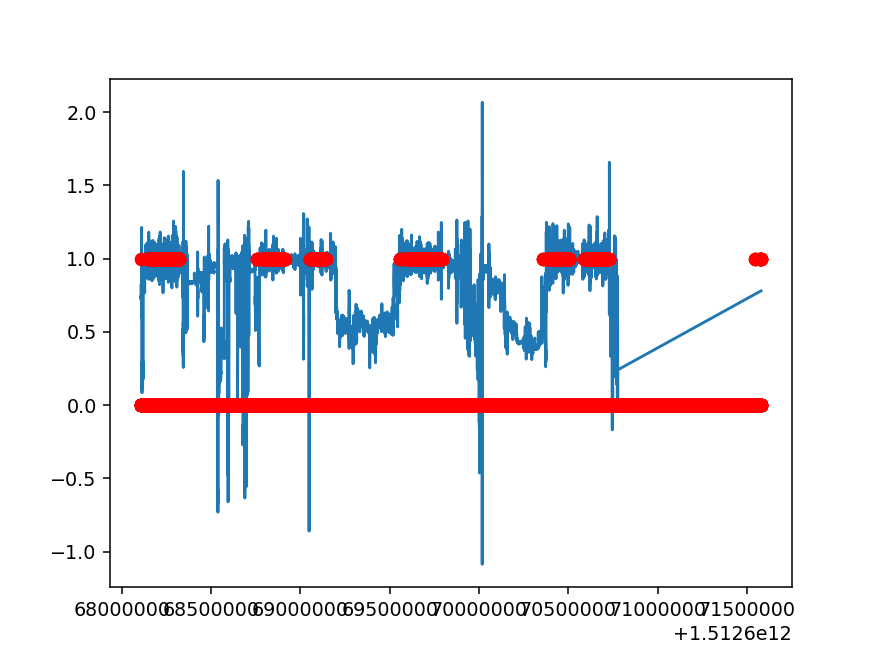

<IPython.core.display.Javascript object>


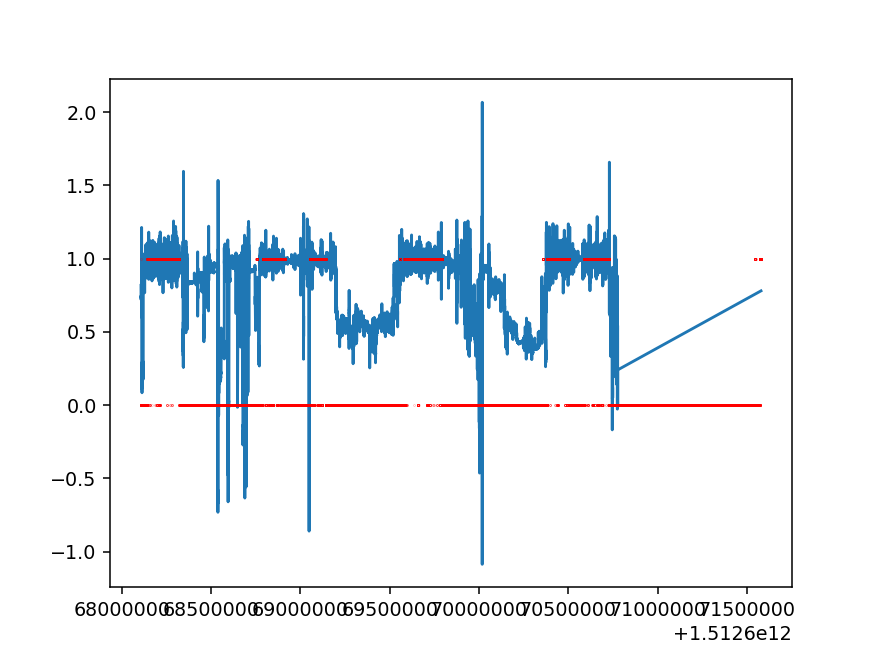

In [3]:
participant_1 = pd.read_pickle('Participant_1.pkl')
#print(participant_1)
labels_1 = np.load('Participant_1_label.npy')
#print(labels_1)

start_time = labels_1[0,0]
end_time = labels_1[-1,0]

dataset = np.copy(participant_1.values)
print(dataset.shape)
print(labels_1.shape)

delta = 40
dataset = dataset[dataset[:,0] >= start_time,:]
dataset = dataset[dataset[:,0] < end_time + delta,:]
print(dataset.shape)

plt.figure()
plt.plot(dataset[:,0],dataset[:,3])
plt.show()
plt.plot(dataset[:,0],labels_1[:,2],'ro')
plt.show()

type_window = 1000
k = int(type_window/delta)
l = len(labels_1)
typing_labels = np.zeros((l,1))
for i in range(0,l):
    if i<(l-k):
        typing_labels[i] = np.amax(labels_1[i:i+k,2])
    else:
        typing_labels[i] = np.amax(labels_1[i:,2])
#print(typing_labels)

plt.figure()
plt.plot(dataset[:,0],dataset[:,3])
plt.show()
plt.plot(dataset[:,0],typing_labels,'r.', ms = 0.1)
plt.show()

Counter({0.0: 65815, 1.0: 17721, 2.0: 3221})
(65815, 1)
(65815, 15)


<IPython.core.display.Javascript object>


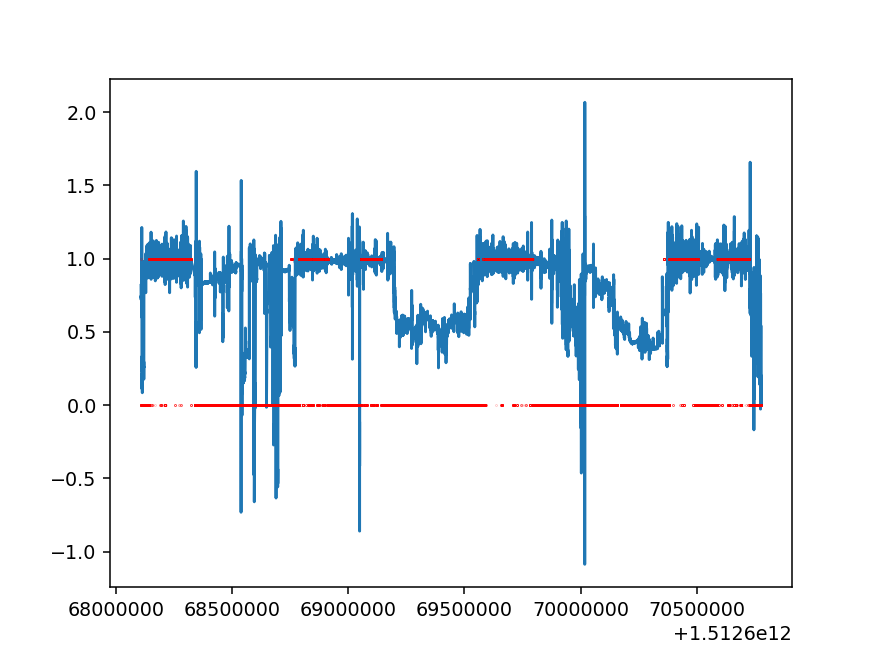

In [4]:
# Remove Missing Data:
missing_1 = dataset[:,13] + dataset[:,14]
print(Counter(missing_1))

dataset = dataset[np.where(missing_1 == 0)]
typing_labels = typing_labels[np.where(missing_1 == 0)]

print(typing_labels.shape)
print(dataset.shape)

plt.figure()
plt.plot(dataset[:,0],dataset[:,3])
plt.show()
plt.plot(dataset[:,0],typing_labels,'r.', ms = 0.1)
plt.show()

In [5]:
dataset_cp = np.copy(dataset[:,1:13])

n_samples, d = dataset_cp.shape
window = 20
stride = 5

data_slide = np.zeros((int((n_samples-window)/stride)+1,window,d))
typing_labels_cp = np.zeros((int((n_samples-window)/stride)+1,1))
k=0
for i in range(0,n_samples-window,stride): #400ms
    data_slide[k,:,:] = dataset_cp[i:i+window,:]
    typing_labels_cp[k] = np.amax(typing_labels[i:i+window])
    k=k+1
    
print (data_slide.shape)
print(typing_labels_cp.shape)

(13160, 20, 12)
(13160, 1)


In [6]:
import numpy as np
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten
from keras.layers.core import Permute, Reshape
from keras import backend as K

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

Using TensorFlow backend.


In [7]:
z = 13000
X_train0 = data_slide[:z]
Y_train = typing_labels_cp[0:z].reshape(-1).astype(np.uint8)
X_test0 = data_slide[z:]
Y_test = typing_labels_cp[z:]
print(np.shape(X_train0))
print(np.shape(Y_train))
print(np.shape(X_test0))
print(np.shape(Y_test))

(13000, 20, 12)
(13000,)
(160, 20, 12)
(160, 1)


In [8]:
num_classes = 2
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

In [9]:
def _data_reshaping(X_tr, X_va, network_type):
    _, win_len, dim = X_tr.shape
    print(network_type)
    if network_type=='CNN' or network_type=='ConvLSTM':
        
        # make it into (frame_number, dimension, window_size, channel=1) for convNet
        X_tr = np.swapaxes(X_tr,1,2)
        X_va = np.swapaxes(X_va,1,2)

        X_tr = np.reshape(X_tr, (-1, dim, win_len, 1))
        X_va = np.reshape(X_va, (-1, dim, win_len, 1))
        
    if network_type=='MLP':
        print('MLP...')
        X_tr = np.reshape(X_tr, (-1, dim*win_len))
        X_va = np.reshape(X_va, (-1, dim*win_len))
    
    return X_tr, X_va


In [10]:

def model_variant(model, num_feat_map, dim, network_type):
    p = 0.4
    print(network_type)
    if network_type == 'ConvLSTM':
        model.add(Permute((2, 1, 3))) # for swap-dimension
        model.add(Reshape((-1,num_feat_map*dim)))
        model.add(LSTM(32, return_sequences=False, stateful=False))
        model.add(Dropout(p))
    if network_type == 'CNN':
        
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(p))

        
def model_conv(model, num_feat_map):
    p=0.3
    model.add(Conv2D(num_feat_map, kernel_size=(1, 5),
                 activation='relu',
                 input_shape=(dim, win_len, 1),
                 padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(p))
    model.add(Conv2D(num_feat_map, kernel_size=(1, 5), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(p))
    
def model_LSTM(model):
    p = 0.3
    model.add(LSTM(num_hidden_lstm, 
               input_shape=(win_len,dim), 
               return_sequences=True))
    model.add(Dropout(p))
    model.add(LSTM(num_hidden_lstm, return_sequences=False))
    model.add(Dropout(p))

def model_MLP(model, num_hidden_mlp):
    p=0.3
    model.add(Dense(num_hidden_mlp, activation='relu', input_shape=(dim*win_len,)))
    model.add(Dropout(p))
    model.add(Dense(num_hidden_mlp, activation='relu'))
    model.add(Dropout(p))
    
def model_output(model):
    model.add(Dense(num_classes, activation='softmax'))
    

In [24]:
batch_size = 1024
num_feat_map = 16
num_hidden_mlp = 128
num_hidden_lstm = 64

#network_type = 'CNN'
#network_type = 'ConvLSTM'
network_type = 'LSTM'
#network_type = 'MLP'
_, win_len, dim = X_train0.shape
print(win_len)
print(dim)

X_train, X_test = _data_reshaping(X_train0, X_test0, network_type)


20
12
LSTM


In [25]:
print('building the model ... ')
model = Sequential()


if network_type=='CNN' or network_type=='ConvLSTM':
    model_conv(model, num_feat_map)
    model_variant(model, num_feat_map, dim, network_type)
if network_type=='LSTM':
    model_LSTM(model)
if network_type=='MLP': 
    model_MLP(model, num_hidden_mlp) 
    
    
    
    
model_output(model)    
model.summary()


building the model ... 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 20, 64)            19712     
_________________________________________________________________
dropout_7 (Dropout)          (None, 20, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 52,866
Trainable params: 52,866
Non-trainable params: 0
_________________________________________________________________


In [26]:
epochs = 20

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

H = model.fit(X_train, Y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            shuffle=True,
            validation_data=(X_test, Y_test))


Train on 13000 samples, validate on 160 samples
Epoch 1/20
13000/13000 [==============================] - 14s - loss: 0.5691 - acc: 0.6882 - val_loss: 0.5248 - val_acc: 0.7000
Epoch 2/20
13000/13000 [==============================] - 11s - loss: 0.4323 - acc: 0.7898 - val_loss: 0.4887 - val_acc: 0.6812
Epoch 3/20
13000/13000 [==============================] - 11s - loss: 0.3600 - acc: 0.8405 - val_loss: 0.3358 - val_acc: 0.7937
Epoch 4/20
13000/13000 [==============================] - 12s - loss: 0.3271 - acc: 0.8592 - val_loss: 0.2330 - val_acc: 0.9125
Epoch 5/20
13000/13000 [==============================] - 11s - loss: 0.3049 - acc: 0.8695 - val_loss: 0.2079 - val_acc: 0.9062
Epoch 6/20
13000/13000 [==============================] - 12s - loss: 0.2841 - acc: 0.8785 - val_loss: 0.1778 - val_acc: 0.9250
Epoch 7/20
13000/13000 [==============================] - 11s - loss: 0.2700 - acc: 0.8856 - val_loss: 0.2094 - val_acc: 0.8813
Epoch 8/20
13000/13000 [==============================] 

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(Y_test, axis=1)
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
print('the mean-f1 score: {:.2f}'.format(np.mean(class_wise_f1)))


[[155   5]
 [  0   0]]
the mean-f1 score: 0.49


C:\Users\Vikranth\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


<IPython.core.display.Javascript object>


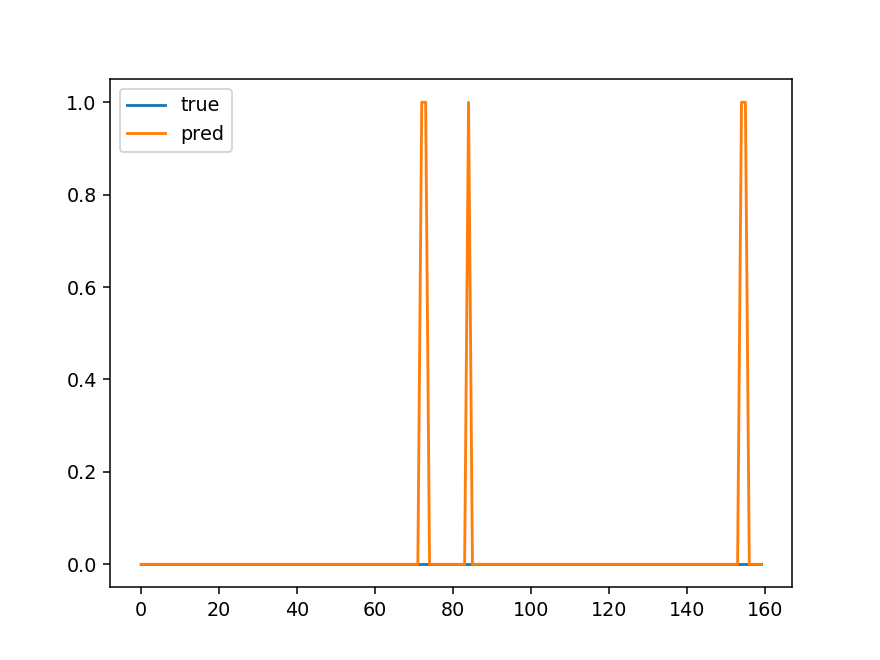

In [28]:
plt.figure()
plt.plot(y_true, label="true")
plt.plot(y_pred, label="pred")

#plt.plot(typing_labels_cp[60000:], label="label")

plt.legend()
plt.show()

In [29]:
model.save('LSTM.h5')